The goal of this project is to predict whether each cell image has any tumor tissue.

In [1]:
import numpy as np
import pandas as pd
import keras,cv2,os
from glob import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
competition_name = "histopathologic-cancer-detection"

from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/Colab Notebooks/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

drive.flush_and_unmount()

In [3]:
path = "/content/kaggle_data/"
train_path = path + "train/"
test_path = path + "test/"

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("/content/kaggle_data/train_labels.csv")
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,/content/kaggle_data/train/e688e7f48dcbcb15f7a...,e688e7f48dcbcb15f7a231fe8bcfe8d85ec18a8a,0
1,/content/kaggle_data/train/be3807be925f4270bd3...,be3807be925f4270bd301201b2895eaefd3b2482,0
2,/content/kaggle_data/train/670a9e6e1183c0ff0bb...,670a9e6e1183c0ff0bb9c562c96d4e53864e5cba,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.7+ MB


In [5]:
def load_data(N,df):

    X = np.zeros([N,96,96,3],dtype=np.uint8)
    y = np.squeeze(df["label"].values[0:N])

    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    return X,y

In [8]:
N=df.shape[0]
X,y = load_data(N=N,df=df)

<ipython-input-5-f61cadb149a0>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/220025 [00:00<?, ?it/s]

In [9]:
X.shape

(220025, 96, 96, 3)

In [10]:
X[0]

array([[[217, 219, 229],
        [225, 219, 238],
        [241, 225, 255],
        ...,
        [208, 200, 211],
        [193, 188, 197],
        [230, 227, 236]],

       [[224, 226, 226],
        [214, 210, 216],
        [224, 211, 227],
        ...,
        [234, 217, 231],
        [170, 158, 170],
        [243, 231, 243]],

       [[235, 230, 227],
        [255, 249, 246],
        [227, 219, 220],
        ...,
        [230, 203, 223],
        [159, 135, 153],
        [253, 231, 249]],

       ...,

       [[166,  83, 185],
        [248, 168, 255],
        [195, 116, 219],
        ...,
        [255, 233, 255],
        [255, 219, 255],
        [173, 138, 165]],

       [[185, 110, 194],
        [251, 176, 255],
        [151,  78, 170],
        ...,
        [180, 119, 185],
        [208, 156, 210],
        [117,  71, 114]],

       [[249, 182, 249],
        [224, 156, 227],
        [120,  51, 131],
        ...,
        [225, 161, 233],
        [242, 182, 246],
        [121,  69, 123]]

In [11]:
y.shape

(220025,)

In [12]:
y[0:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

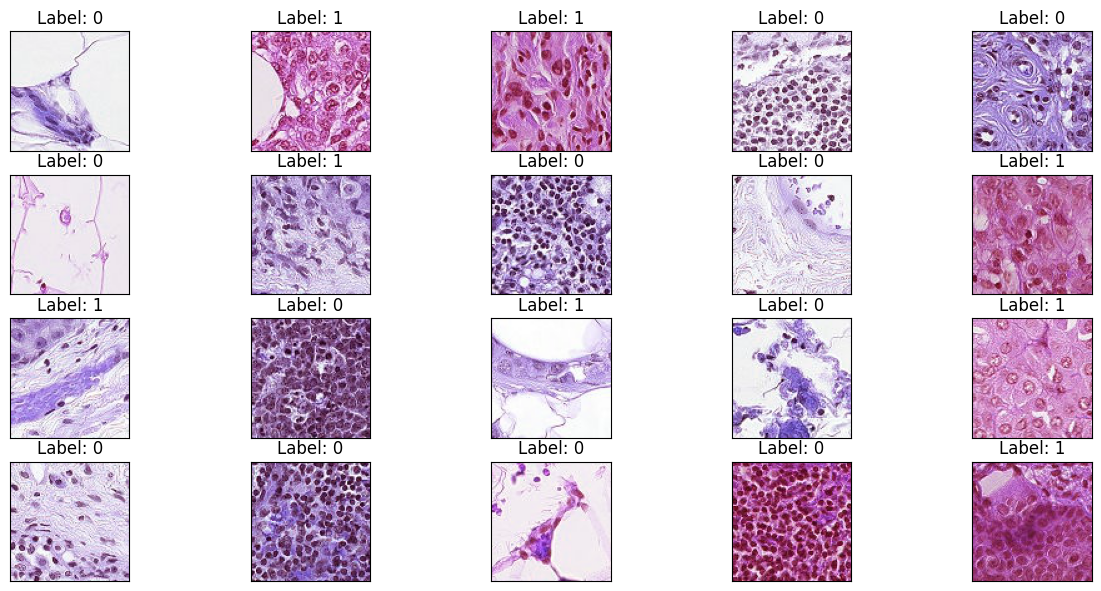

In [25]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(20):
    n += 1
    r = np.random.randint(0 , X.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.imshow(X[r[0]])
    plt.title(f"Label: {y[r[0]]}")
    plt.xticks([]) , plt.yticks([])

plt.show()

In [26]:
(y==0).sum() # Negative results

130908

In [27]:
(y==1).sum() # Positive results

89117

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I decide to go with a CNN architecture which has 3 convolution blocks and utilizes dropout for regularization. I use "relu" activation functions and max pooling. In the output layer, I use a "sigmoid" function to make the classification. During training, I use early stoppage which automatically stops training if the validation accuracy doesn't increase over a period of 3 epochs. This way, the model does not over-fit.

In [35]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))

In [36]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = [es])

Epoch 1/100
1761/1761 [==============================] - 87s 43ms/step - loss: 0.3384 - accuracy: 0.8566 - val_loss: 0.4345 - val_accuracy: 0.8354
Epoch 2/100
1761/1761 [==============================] - 73s 42ms/step - loss: 0.2436 - accuracy: 0.9028 - val_loss: 0.4061 - val_accuracy: 0.8408
Epoch 3/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.2058 - accuracy: 0.9203 - val_loss: 0.5309 - val_accuracy: 0.8226
Epoch 4/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1844 - accuracy: 0.9295 - val_loss: 0.2560 - val_accuracy: 0.8949
Epoch 5/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1711 - accuracy: 0.9351 - val_loss: 0.2177 - val_accuracy: 0.9171
Epoch 6/100
1761/1761 [==============================] - 73s 41ms/step - loss: 0.1605 - accuracy: 0.9397 - val_loss: 0.6307 - val_accuracy: 0.7912
Epoch 7/100
1761/1761 [==============================] - 72s 41ms/step - loss: 0.1508 - accuracy: 0.9436 - val_loss: 0

In [ ]:
model.evaluate(X_test, y_test)

1376/1376 [==============================] - 6s 4ms/step - loss: 0.3684 - accuracy: 0.8575


[0.3683735430240631, 0.8575161695480347]

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

1376/1376 [==============================] - 5s 3ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     26304
           1       0.75      0.96      0.84     17701

    accuracy                           0.86     44005
   macro avg       0.86      0.87      0.86     44005
weighted avg       0.88      0.86      0.86     44005



<Axes: >

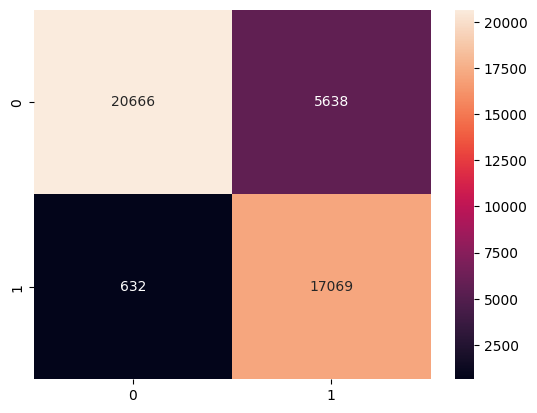

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="g")

I also create a pre-trained ResNet50 model to compare results.

In [40]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50_base_model = ResNet50(weights = 'imagenet', include_top = False,pooling = max, input_shape = (96, 96, 3))
resnet50_model = Sequential([
    resnet50_base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1,activation="sigmoid")
])


In [41]:
resnet50_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
history_resnet50 = resnet50_model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks = [es])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1761/1761 [==============================] - 152s 77ms/step - loss: 0.2725 - accuracy: 0.8952 - val_loss: 0.4911 - val_accuracy: 0.8262
Epoch 2/100
1761/1761 [==============================] - 132s 75ms/step - loss: 0.2229 - accuracy: 0.9131 - val_loss: 0.2808 - val_accuracy: 0.8848
Epoch 3/100
1761/1761 [==============================] - 132s 75ms/step - loss: 0.1750 - accuracy: 0.9343 - val_loss: 1.2052 - val_accuracy: 0.7097
Epoch 4/100
1761/1761 [==============================] - 133s 75ms/step - loss: 0.1692 - accuracy: 0.9363 - val_loss: 0.3463 - val_accuracy: 0.8937
Epoch 5/100
1761/1761 [==============================] - 132s 75ms/step - loss: 0.1282 - accuracy: 0.9536 - val_loss: 0.1740 - val_accuracy: 0.9383
Epoch 6/100
1761/1761 [==============================] - 132s 75ms/step - loss: 0.1574 - accuracy: 0.9419 - val_loss: 0.3818 - val_accuracy: 0.8672
Epoch 7/100
1761/1761 [==============================] - 132s 75ms/step - loss: 0.1164 - accuracy: 0.9580 - val_loss: 0.2661

In [45]:
resnet50_model.evaluate(X_test, y_test)

1376/1376 [==============================] - 15s 11ms/step - loss: 0.2545 - accuracy: 0.9132


[0.25454914569854736, 0.913214385509491]

In [65]:
y_pred = (resnet50_model.predict(X_test) > 0.5).astype("int32")

1376/1376 [==============================] - 12s 9ms/step


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     26190
           1       0.97      0.81      0.88     17815

    accuracy                           0.91     44005
   macro avg       0.93      0.90      0.91     44005
weighted avg       0.92      0.91      0.91     44005



<Axes: >

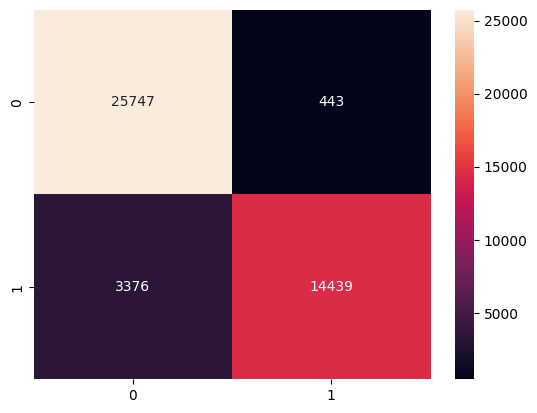

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="g")

In [43]:
base_test_dir = path + 'test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 10000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(cv2.imread)
    K_test = np.stack(test_df["image"].values)
    predictions = resnet50_model.predict(K_test,verbose = 1)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

234/234 [==============================] - 2s 10ms/step


,id,label
0,4b416d0c3cf11891d812f96e03b03bf33c5460b5,0.000672
1,bd81b81c2f37a2ef2b91680592182d099fd8f57d,0.501113
2,97c6fc0e4f2bed1efd008754f42b7afb8f2d33d5,0.973838
3,526920e592cc5a409dc0d15d534fa463657de360,0.000055
4,ffd830b397c1a03c35688ccf898667832cff89f8,0.533974


In [44]:
submission.to_csv("submission.csv", index = False, header = True)

Although the ResNet50 model performed better than my simple model on my test data (91.32% accuracy and 91% F1 score versus 85.75% accuracy and 86% F1 score), my submission for the simple model performed better on the Kaggle test data, which achieved a 93.91% public score. In conclusion, my simple model performed with a 85.75% accuracy and 86% F1 score on the test set (which I created from 20% of the orginal training data during my train test split). I am surprised that my simple model performed better than the ResNet50 model, and I am pleased with the accuracy of both models considering how complex the images are. Originally, I tried a higher dropout of 50% (compared to the current 20%), but that higher dropout performed worse so I decreased it. Since there were over 200,000 images, I did not use data augmentation, but to improve results I can use data augmentation to create even more training data, which may improve results but would take a longer time to train. My submission predictions achieved a public score of 93.91% on Kaggle.